# Let's Write an HOD Code!
*University of Michigan Cosmology Summer School 2023*

Author: Lehman Garrison (Scientific Computing Core, Flatiron Institute, [github.com/lgarrison](https://github.com/lgarrison))

## Introduction
The halo occupation distribution (HOD) is a common model of the galaxy-halo connection used in analyzing galaxy surveys.  Its empiricism and flexibility allows us to connect $N$-body simulations to galaxy clustering.  The ideas behind HOD are relatively simple; we can write a basic HOD code in a few dozen lines of Python code.  Let's try it!



### Goals
In this notebook, you'll learn how to
- **Load a halo catalog** from an Abacus N-body simulation and explore some basic properties of the simulation
- Make selections on the halo catalog and **measure the clustering** using Corrfunc
- Generate populations of **central and satellite galaxies** using Numpy, placing the satellites on halo particles
- Upgrade the Numpy implementation to a high-performance **Numba** implementation

## Setup
To get started, run the following cell to set up your Colab environment and install the Python dependencies.

In [1]:
!apt install libgsl-dev
!pip install abacusutils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgsl-dev is already the newest version (2.7.1+dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
!pip install corrfunc

Download and extract the halo catalog we'll be working with:

In [3]:
# If the first command fails, try one of the others
!wget https://d1qdmld16vdglj.cloudfront.net/AbacusSummit_hugebase_c000_ph000-z0.500.tar
# !gdown https://drive.google.com/uc?id=1vXqqX5vChMQ0Tj5oJ705XM08ZShpbfvc
# !wget https://users.flatironinstitute.org/~lgarrison/AbacusSummit/umich/AbacusSummit_hugebase_c000_ph000-z0.500.tar

--2024-09-02 07:25:09--  https://d1qdmld16vdglj.cloudfront.net/AbacusSummit_hugebase_c000_ph000-z0.500.tar
Resolving d1qdmld16vdglj.cloudfront.net (d1qdmld16vdglj.cloudfront.net)... 52.84.248.179, 52.84.248.47, 52.84.248.231, ...
Connecting to d1qdmld16vdglj.cloudfront.net (d1qdmld16vdglj.cloudfront.net)|52.84.248.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4865320960 (4.5G) [application/x-tar]
Saving to: ‘AbacusSummit_hugebase_c000_ph000-z0.500.tar.2’

AbacusSummit_hugeba 100%[===================>]   4.53G  75.3MB/s    in 68s     

2024-09-02 07:26:17 (68.2 MB/s) - ‘AbacusSummit_hugebase_c000_ph000-z0.500.tar.2’ saved [4865320960/4865320960]



In [28]:
!tar -xf AbacusSummit_hugebase_c000_ph000-z0.500.tar

Run the following cell to import all the Python packages we'll need later in this notebook:

In [29]:
import math

from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import scipy
import numpy.typing as npt

## Loading the halo catalog

Let's load the halo catalog and get some familiarity with the data model. The catalog we're using is a $z=0.5$ output from the simulation called `AbacusSummit_hugebase_c000_ph000`, which is a $L=2000\ \mathrm{Mpc}/h$ simulation with $N=2304^3$ particles from the [AbacusSummit](https://abacussummit.readthedocs.io) suite.  The halo finder is called CompaSO.

We'll indicate that we want to load the 3% subsample of halo particles (the "A" subsample) with `subsamples=dict(A=True, pos=True)`.  We'll use it later for satellites.

In [30]:
cat = CompaSOHaloCatalog(
    'AbacusSummit_hugebase_c000_ph000/halos/z0.500',
    subsamples=dict(A=True, pos=True),
    fields=('N', 'x_L2com'),
)

Printing the `cat` object yields some info about the catalog:


In [31]:
print(cat)

CompaSO Halo Catalog
AbacusSummit_hugebase_c000_ph000 @ z=0.5
----------------------------------------
     Halos:  1.7e+07 halos,       4 fields,   0.475 GB
Subsamples: 6.85e+07 particles,   1 field ,   0.822 GB
Cleaned halos: True
Halo light cone: False


The table of halo properties is stored in `cat.halos`, which we'll store in variable `h` since we'll use it a lot.  We'll also use `h.meta` to get the box size.

In [32]:
h = cat.halos
L = h.meta['BoxSize']
print(L)
h

2000.0


x_L2com,npstartA,npoutA,N
float32[3],int64,uint32,uint32
-997.73285 .. -899.89874,0,0,48
-996.68335 .. -859.6516,0,0,58
-995.93896 .. -835.17224,0,0,43
-999.4892 .. -833.2039,0,3,52
-999.0532 .. -789.909,3,0,43
-996.3567 .. -780.75574,3,1,36
-996.87775 .. -772.9002,4,0,38
-995.32025 .. -761.6241,4,1,100
-995.8008 .. -754.47284,5,1,50


`h.meta` holds useful metadata, like the particle mass `h.meta['ParticleMassHMsun']`.

Use this and the `'N'` column to add a new column called `'M'` with the halo mass to the table `h`. Make sure to give it Numpy `dtype` `np.float32` (this will help with performance later).

In [33]:
h['M']=h['N']*h.meta['ParticleMassHMsun']
h

x_L2com,npstartA,npoutA,N,M
float32[3],int64,uint32,uint32,float64
-997.73285 .. -899.89874,0,0,48,2733369650507.1694
-996.68335 .. -859.6516,0,0,58,3302821661029.4966
-995.93896 .. -835.17224,0,0,43,2448643645246.006
-999.4892 .. -833.2039,0,3,52,2961150454716.1
-999.0532 .. -789.909,3,0,43,2448643645246.006
-996.3567 .. -780.75574,3,1,36,2050027237880.377
-996.87775 .. -772.9002,4,0,38,2163917639984.8425
-995.32025 .. -761.6241,4,1,100,5694520105223.27
-995.8008 .. -754.47284,5,1,50,2847260052611.635


And print $\log_{10}$ of the minimum and maximum *non-zero* mass:

In [34]:
print(np.log10(np.nanmin(h['M'][np.nonzero(h['M'])])),np.log10(np.max(h['M'][np.nonzero(h['M'])])))

12.299525174971699 15.41571530982764


(Some halos have zero mass to indicate they have been removed from the catalog in the merger tree "cleaning" process)

Typical LRG (luminous red galaxy) host halo mass is $10^{13}$, so this should be a good halo catalog for LRG modeling.

## Plotting the halo field
Let's visualize the halo field. Make a 2D plot of the halo centers (`x_L2com` in the catalog).  The X axis should be the X coordinate, and the Y axis should be the Y coordinate, both in Mpc/$h$ units.

Hint: don't do a scatterplot! 17 million points is too many for matplotlib. Use a 2D histogram.

In [35]:
np.shape(h['x_L2com'][0])

(3,)

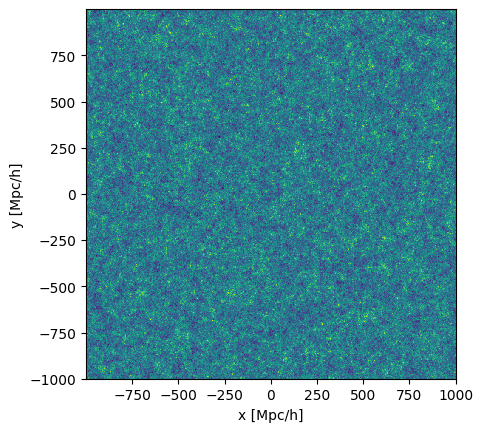

In [36]:
fig,ax=plt.subplots()
ax.hist2d(h['x_L2com'][:,0],h['x_L2com'][:,1],bins=500)
ax.set_xlabel('x [Mpc/h]')
ax.set_ylabel('y [Mpc/h]')
ax.set_aspect('equal')

### Bonus
Make another scatter plot with a 40 Mpc/$h$ deep slice (40 Mpc/$h$ cut in Z).

Hint: a thin slice like this will show the cosmic web more clearly, but will have many cells with zero counts. A log scale will make these infs or nans; you'll probably need to either adjust the color map or use a non-log scale.

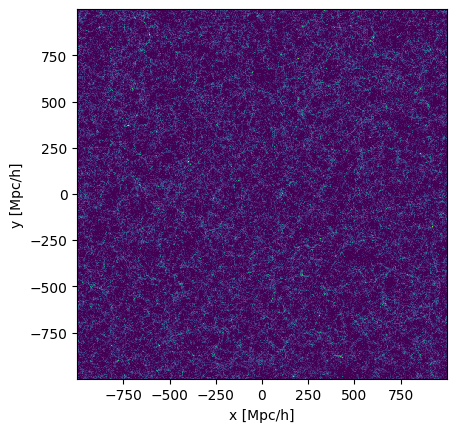

In [37]:
def plot_slice(z):

    hsel=h[(h['x_L2com'][:,2]>z-20) & (h['x_L2com'][:,2]<z+20)]

    fig,ax=plt.subplots()
    ax.hist2d(hsel['x_L2com'][:,0],hsel['x_L2com'][:,1],bins=500,norm='linear')
    ax.set_xlabel('x [Mpc/h]')
    ax.set_ylabel('y [Mpc/h]')
    ax.set_aspect('equal')

plot_slice(0)

## Measuring the 2PCF
Use Corrfunc to measure the two-point correlation function of large halos, following these steps:
1. Make selection of halos with mass $\ge 10^{13} M_\odot/h$
1. Wrap the input positions to $[0,L)$
1. Use the `Corrfunc.theory.xi()` function to count pairs ([`xi` API](https://corrfunc.readthedocs.io/en/master/api/Corrfunc.theory.html#Corrfunc.theory.xi))
    - Use 40 bins between 1 and 120 Mpc/$h$ (linear spacing)
    - Use 2 threads (Google Colab limit)
    - Should run in < 60 sec
1. Plot the 2PCF and label the axes. Can you see a bump at 100 Mpc/h? Use a `symlog` scale if needed.

Start by filling out the function below, following its argument type annotations. If you haven't seen Python type annotations before, they're just hints to the programmer about what the types of arguments and return values are.

In [38]:
from Corrfunc.theory.xi import xi

def compute_xi(pos: npt.NDArray[np.float32],
               bins: npt.NDArray[np.float32],
               ) -> Table:

    results = xi(L, 2, bins,  *pos.T % L,verbose=True)
    results=Table(results)

    return results

big_h=h['x_L2com'][h['M']>=1e13]
big_h+=L/2
bins=np.linspace(1,120,41)

res=compute_xi(big_h,bins)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,16.  Time taken =   0.242 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 41.875 secs


In [39]:
res

rmin,rmax,ravg,xi,npairs,weightavg
float64,float64,float64,float64,uint64,float64
1.0,3.975,0.0,6.527585506439209,1811446,0.0
3.975,6.95,0.0,2.12241268157959,3317526,0.0
6.95,9.925,0.0,1.0445783138275146,5110276,0.0
9.925,12.9,0.0,0.6190024614334106,7368826,0.0
12.9,15.875,0.0,0.40164637565612793,10117908,0.0
15.875,18.85,0.0,0.27677595615386963,13407176,0.0
18.85,21.825,0.0,0.1985567808151245,17256960,0.0
21.825,24.8,0.0,0.14707565307617188,21691794,0.0
24.8,27.775000000000002,0.0,0.1110299825668335,26706964,0.0


In [ ]:
# If you get a RuntimeError, you might have to restart your runtime to clear the error.
# You DON'T need to redownload the data, just start from the "import..." cell
# To restart the runtime, click Runtime -> Restart Runtime

Text(0, 0.5, '2pCF')

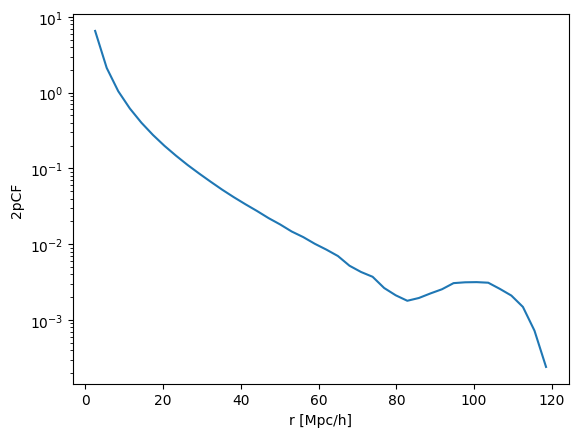

In [40]:
fig,ax=plt.subplots()
ax.plot(0.5*(res['rmin']+res['rmax']),res['xi'])
ax.set_yscale('log')
ax.set_xlabel('r [Mpc/h]')
ax.set_ylabel('2pCF')

## Generate HOD Centrals
Let's paint galaxies onto our halos, using the standard [Zheng, et al. (2005)](https://arxiv.org/abs/astro-ph/0408564) HOD.  We'll start with centrals: galaxies placed at or near the halo center.

The mean occupation of central galaxies in halos (i.e. the number of galaxies per halo) is given by:
$$
\langle N_\mathrm{cen} \rangle_M = \frac{1}{2} \left [ 1 + \mathrm{erf} \left ( \frac{\log_{10} M - \log_{10} M_\mathrm{min}}{ \sigma_{\log M}} \right) \right]
$$

Implement this in Python, following the function signature below.

Hint: Numpy doesn't have an $\mathrm{erf}$ function, but SciPy does.

In [41]:
from scipy.special import erf

def n_cen(M: npt.NDArray[np.float32],
          log_Mmin: np.float32,
          sigma_logM: np.float32,
          ) -> npt.NDArray[np.float32]:

    return 0.5*(1+erf((np.log10(M)-log_Mmin)/sigma_logM))

Plot `n_cen()` versus mass, using `logM_min=13.5` and `sigma_logM=0.2`.

Text(0, 0.5, '$<N_{cen}>_M$')

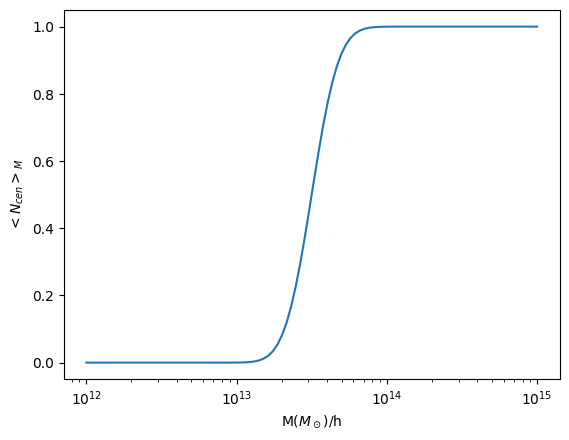

In [42]:
fig,ax=plt.subplots()
x=np.logspace(12,15,100)
ax.plot(x,n_cen(x,13.5,0.2))
ax.set_xscale('log')
ax.set_xlabel('M($M_\odot$)/h')
ax.set_ylabel('$<N_{cen}>_M$')

Select halo centers to be part of the galaxy sample with probability given by `n_cen()`.

In [43]:
def make_cen(h: Table,
             log_Mmin: np.float32,
             sigma_logM: np.float32,
             seed: int = 123,
             ) -> npt.NDArray[np.float32]:

    h['p_cen']=n_cen(h['M'],log_Mmin, sigma_logM)

    rng=np.random.default_rng(42)
    rand=np.random.rand(len(h))
    hsel=h['x_L2com'][h['p_cen']>rand]

    return hsel

hsel=make_cen(h,13.5,0.2)
hsel

<ipython-input-41-e7127a0b46e4>:8: RuntimeWarning: divide by zero encountered in log10
  return 0.5*(1+erf((np.log10(M)-log_Mmin)/sigma_logM))


<Column name='x_L2com' dtype='float32' shape=(3,) length=625918>
-998.7801 .. -561.62506
 -998.2887 .. -535.5394
 -995.1339 .. 365.96814
-994.59515 .. 366.75137
 -994.90625 .. 714.9003
-996.60266 .. -661.1757
-995.5683 .. -362.86035
-995.3573 .. -344.43185
-995.3506 .. -3.6098933
-995.84973 .. -3.012719
 -994.4605 .. 266.91028
 -999.0603 .. -798.2633
                    ...
-999.5371 .. -348.36133
 997.76904 .. -88.82455
 999.36224 .. 458.70078
 997.37177 .. 18.020716
  998.9973 .. 136.68312
  997.6729 .. 146.46626
  -999.109 .. 466.02216
-999.31433 .. 513.39325
999.66516 .. -467.29266
 -999.3534 .. 136.85727
   999.411 .. 488.66785

Measure and plot the 2PCF of this sample ("central galaxies") on two scales:
1. First do the large-scale 2PCF to check that it looks similar to the halo 2PCF that we did before (i.e. you can see the BAO feature)
2. Then plot the small-scale 2PCF from 0.1 Mpc/$h$ to 20 Mpc/$h$. Use a log-log scale.
Why does the small-scale 2PCF look this way?

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,16.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.190 secs


Text(0, 0.5, '2pCF')

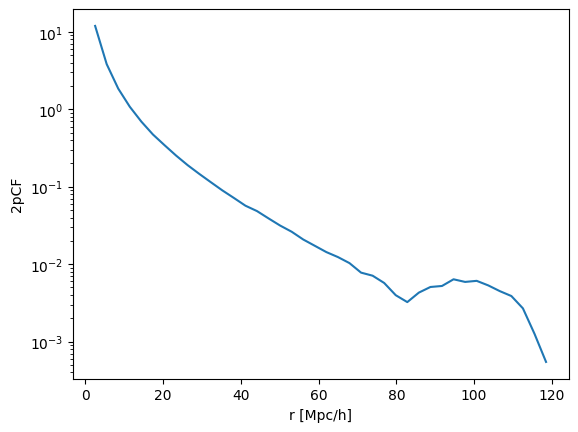

In [44]:
res=compute_xi(hsel,bins)
fig,ax=plt.subplots()
ax.plot(0.5*(res['rmin']+res['rmax']),res['xi'])
ax.set_yscale('log')
ax.set_xlabel('r [Mpc/h]')
ax.set_ylabel('2pCF')

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,100.  Time taken =   0.452 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.891 secs


Text(0, 0.5, '2pCF')

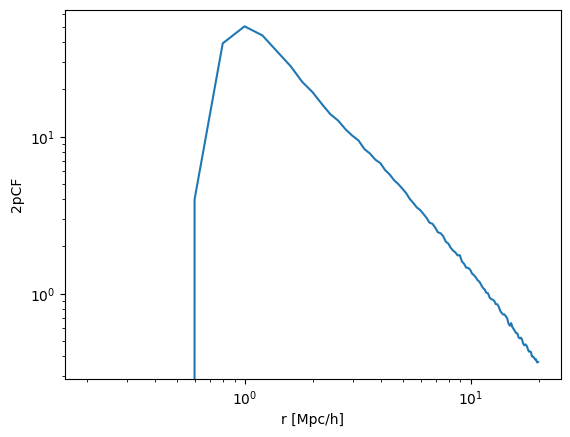

In [45]:
bins=np.linspace(0.1,20,101)
res=compute_xi(hsel,bins)
fig,ax=plt.subplots()
ax.plot(0.5*(res['rmin']+res['rmax']),res['xi'])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('r [Mpc/h]')
ax.set_ylabel('2pCF')

## Generate HOD Satellites
In the Zheng, et al. (2005) HOD, the mean occupation of satellites in halos is given by
$$
\langle N_\mathrm{sat}\rangle_M = [(M - \kappa M_\mathrm{min})/M_1]^\alpha
$$
This is a function of three new parameters $\kappa$, $M_1$, and $\alpha$ ($M_\mathrm{min}$ is already set by the central HOD).

Complete the body of the `n_sat()` function below.

In [46]:
def n_sat(M: npt.NDArray[np.float32],
          logM_min: np.float32,
          kappa: np.float32,
          logM_1: np.float32,
          alpha: np.float32,
          ) -> npt.NDArray[np.float32]:

    res= np.power((M-kappa*np.power(10,logM_min))/np.power(10,logM_1),alpha)
    res[res<0]=0
    return res

Plot the satellite occupation distribution on the same plot as the centrals occupation distribution.  (For simplicity, just copy and edit your centrals HOD plotting code). Use `logM_min=13.1`, `kappa=2.`, `logM_1 = 14`, `alpha=1.`.

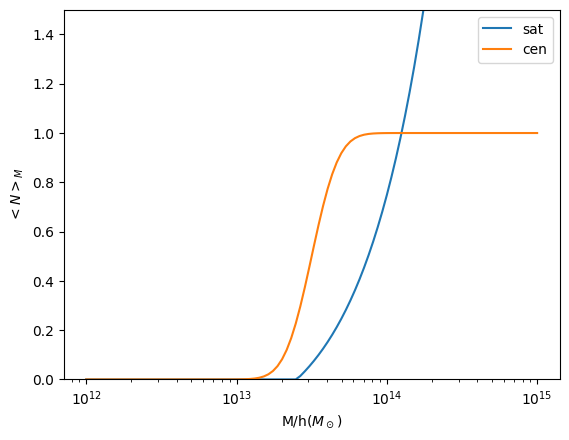

In [47]:
fig,ax=plt.subplots()
x=np.logspace(12,15,100)

ax.plot(x,n_sat(x,13.1,2.,14,1.),label='sat')
ax.plot(x,n_cen(x,13.5,0.2),label='cen')

ax.set_ylim(0,1.5)
ax.set_xscale('log')
ax.set_xlabel('M/h($M_\odot$)')
ax.set_ylabel('$<N>_M$')
ax.legend()

Now generate satellite galaxies by placing them on halo particles.

The halo particle positions are stored in `cat.subsamples['pos']`.  The particles are stored in halo order.  So halo `i` has `h[i]['npoutA']` subsample particles, followed by halo `i+1`'s `h[i+1]['npoutA']` subsample particles, etc.

 The `A` refers to "subsample A", which is a random 3% sample of particles.

Hint: don't write a Python loop over halos! Your implementation should be about 2-4 lines of code using Numpy.

In [48]:
def gen_sat(nsat_per_halo: npt.NDArray[np.float32],
            randoms: npt.NDArray[np.float32],
            ) -> npt.NDArray[np.float32]:
    sat_pos= cat.subsamples['pos'][np.repeat(nsat_per_halo/h['npoutA'], h['npoutA'])>randoms]
    return sat_pos

rng = np.random.default_rng(123)
nsat_per_halo = n_sat(h['M'], 13.1, 2, 14., 1.)
randoms = rng.random(h['npoutA'].sum(), dtype=np.float32)
sat_pos = gen_sat(nsat_per_halo, randoms)

<ipython-input-48-703ac87dcf41>:4: RuntimeWarning: invalid value encountered in divide
  sat_pos= cat.subsamples['pos'][np.repeat(nsat_per_halo/h['npoutA'], h['npoutA'])>randoms]


In [49]:
len(sat_pos)

239496

Measure the small-scale clustering (from 0.1 to 20 Mpc/$h$) and plot it on the same axes as the 2PCF of centrals.

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,100.  Time taken =   0.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.224 secs


Text(0, 0.5, '2pCF')

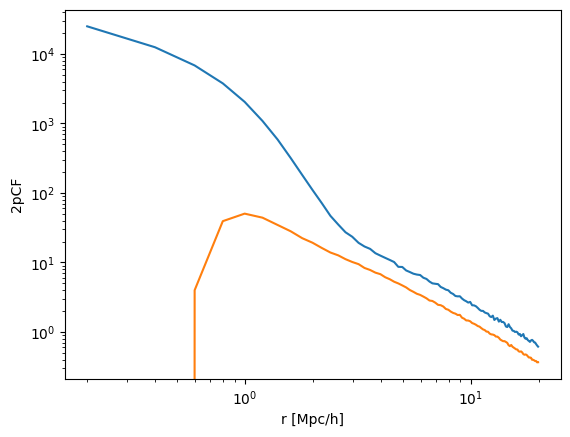

In [50]:
bins=np.linspace(0.1,20,101)
res2=compute_xi(sat_pos,bins)
fig,ax=plt.subplots()
ax.plot(0.5*(res2['rmin']+res2['rmax']),res2['xi'])
ax.plot(0.5*(res['rmin']+res['rmax']),res['xi'])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('r [Mpc/h]')
ax.set_ylabel('2pCF')